# A Primer on Computer Vision

## Introduction

For a specific project on the housing market ([here](https://julienpascal.github.io/project/rentalmarket/)), I had to analyze thousands of photos. To do that, I used a **convolutional neural network** (CNN), which is a fancy name for a complicated function that can be "trained" to recognize patterns in images. In this blog post, I would like to introduce the **"Hello World"** of computer vision and CNN: the classification of hand-written digits from the MNIST dataset. There are thousands of tutorials on the same topic using Python freely available on the Internet. Instead, let's use Julia and the package **Flux.jl**. Why? Because **Julia is fast**, and if you have millions of images to analyze, the speed up could be substantial compared to Python.

## Data

The MNIST dataset contains images of hand-written digits (0 to 9) in grayscale and that are nicely centered. Each pixel is represented by a number in between 0 (black) and 255 (white). Each image is 28 by 28 pixels. One way to represent an image is to see it as a 1d-column vector of 28*28 = 784 pixels. However, this representation ignores the "structure" of an image: pixels that are close to each others are informative on the digit we are trying to identify. A CNN is a good tool to keep the spatial structure of an image, while avoiding issues linked to the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality): images are noisy and high-dimensional input data.

## A crash course on CNN

Two of the key ingredients of a CNN are a **convolutional layer** (hence the name) and a **maxpool layer**.

### Convolutional layer

A convolutional layer applies a *stencil* to each point. The output of a convolutional layer is an "image" of lower dimension, that is informative on some features of the input image (shapes, edges, etc.). The figure below shows how a convolutional layer works:


![alt text](https://miro.medium.com/max/526/1*GcI7G-JLAQiEoCON7xFbhg.gif) 
source:https://mitmath.github.io/18337/lecture14/pdes_and_convolutions

### Maxpool layer

A maxpool layer is a *stencil* that selects the maximum value within a square. Below is an illustration of a maxpool layer applied to a $ 4 \times 4$ image:

![alt text](https://mauriciocodesso.com/img/convolution/maxpooling.gif)
source:https://mauriciocodesso.com/post/convolution-neural-network/

### Stride and Padding 

When building a CNN, one must specify two hyper parameters: **stride and padding**

* When the stride is equal to 1, we move the filters one pixel at a time. When stride is equal to 2, we move the filters two pixel at a time, etc.

* Padding refers to "adding zeroes" at the border of an image. Padding can be used to control the size of the output volume and helps in keeping information at the border of images

Below is an example of a $3 \times 3$ filter applied to a $5 \times 5$ input padded with a $1 \times 1$ border of zeros using $2 \times 2$ strides:

![alt text](padding_strides.gif)
source: http://deeplearning.net/software/theano/tutorial/conv_arithmetic.html

The typical infrastructure of a CNN is first to apply a convolutional layer to the input image, then to use a maxpool layer, before using a fully-connected layer. Several "convolutional layer - maxpool layer" units can be stacked together before using a fully-connected (FC) layer. Note that an activation layer (often [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks))) is generally inserted between the the convolutional and the maxpool layer.

![alt text](architecture.png)
source: https://towardsdatascience.com/visualizing-the-fundamentals-of-convolutional-neural-networks-6021e5b07f69

## Using Flux.jl

Flux.jl is a leading machine learning package in the Julia ecosystem. In what follows, we load both the train and the test samples of the MNIST dataset. The train sample is a set of images used to fine-tune the parameters of the CNN, while the test sample contains images used to check that we did not overfit the train sample. A smoking gun for overfitting is when the accuracy in the train sample is much better than the accuracy using images from the test sample.

Images in the train set: (60000,)Images in the test set: (10000,)

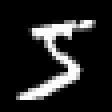

In [10]:
using Flux, Flux.Data.MNIST, Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle
using Base.Iterators: repeated, partition
using Printf, BSON
using ImageView

# Load labels and images from Flux.Data.MNIST
# Train set: images used to estimate the CNN
train_labels = MNIST.labels(:train)
train_imgs = MNIST.images(:train);

# Test set: images used to see how well the CNN perform "out-of-the-sample"
test_imgs = MNIST.images(:test)
test_labels = MNIST.labels(:test)

print("Images in the train set: $(size(train_imgs))")
print("Images in the test set: $(size(test_imgs))")

# Visualization of one digit
NROWS, NCOLS = 28, 28
a = reshape(train_imgs[1], NROWS, NCOLS)

## CNN architecture

Our CNN has the usual CONV->ReLU->MaxPool components, before using a FC layer. We use a $1 \times 1$ padding and a stride of $1$ (the default value). The size of input is gradually reduced by using $2 \times 2$ maxpool layers:

In [11]:
model = Chain(
    # First convolution, operating upon a 28x28 image
    Conv((3, 3), 1=>16, pad=(1,1), relu),
    MaxPool((2,2)), #maxpooling

    # Second convolution, operating upon a 14x14 image
    Conv((3, 3), 16=>32, pad=(1,1), relu),
    MaxPool((2,2)), #maxpooling

    # Third convolution, operating upon a 7x7 image
    Conv((3, 3), 32=>32,pad=(1,1), relu),
    MaxPool((2,2)),

    # Reshape 3d tensor into a 2d one, at this point it should be (3, 3, 32, N)
    # which is where we get the 288 in the `Dense` layer below:
    x -> reshape(x, :, size(x, 4)),
    Dense(288, 10),

    # Softmax to get probabilities
    softmax,
)

Chain(Conv((3, 3), 1=>16, NNlib.relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Conv((3, 3), 16=>32, NNlib.relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Conv((3, 3), 32=>32, NNlib.relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), getfield(Main, Symbol("##7#8"))(), Dense(288, 10), NNlib.softmax)

## Training

### Batching

The batch size is a parameter that tells us how many images the network will "see" at once when "training".
In technical terms, when performing gradient descent, we don't use all the information at once (because of memory limitations and because it is not necessarily efficient). The following function generates "batches" of images:

In [12]:
# Bundle images together with labels and group into minibatchess
function make_minibatch(X, Y, idxs)
    X_batch = Array{Float32}(undef, size(X[1])..., 1, length(idxs))
    for i in 1:length(idxs)
        X_batch[:, :, :, i] = Float32.(X[idxs[i]])
    end
    Y_batch = onehotbatch(Y[idxs], 0:9)
    return (X_batch, Y_batch)
end
# The CNN only "sees" 128 images at each training cycle:
batch_size = 128
mb_idxs = partition(1:length(train_imgs), batch_size)
# train set in the form of batches
train_set = [make_minibatch(train_imgs, train_labels, i) for i in mb_idxs];
# train set in one-go: used to calculate accuracy with the train set
train_set_full = make_minibatch(train_imgs, train_labels, 1:length(train_imgs));
# test set: to check we do not overfit the train data:
test_set = make_minibatch(test_imgs, test_labels, 1:length(test_imgs));

### Loss function and minimization

For the CNN to "learn" anything at all, it must have a notion of "wrong" or "right". The loss function does exactly that, by quantifying how well the model performs at recognizing digits. When the output is a probability, the [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) loss function is appropriate. The final step is to select an algorithm to minimize the loss function. Here, let's select the [ADAM](https://arxiv.org/abs/1412.6980) algorithm, which I understand as some sort of [Stochastic Gradient Descent](https://julienpascal.github.io/post/ols_ml/) with momentum and adaptive learning rate:

In [13]:
# `loss()` calculates the crossentropy loss between our prediction `y_hat`
# We augment the data a bit, adding gaussian random noise to our image to make it more robust.
function loss(x, y)
    # We augment `x` a little bit here, adding in random noise
    x_aug = x .+ 0.1f0*gpu(randn(eltype(x), size(x)))

    y_hat = model(x_aug)
    return crossentropy(y_hat, y)
end
accuracy(x, y) = mean(onecold(model(x)) .== onecold(y))

# ADAM optimizer
opt = ADAM(0.001);

This block "train" (fine-tune the CNN parameter values) the model until a pre-determined accuracy level is reached:

In [14]:
best_acc = 0.0
last_improvement = 0
accuracy_target = 0.97 #When we should stop training
max_epochs = 100 #Maximum
for epoch_idx in 1:100
    global best_acc, last_improvement
    # Train for a single epoch
    Flux.train!(loss, params(model), train_set, opt)

    # Calculate accuracy:
    acc = accuracy(train_set_full...)
    @info(@sprintf("[%d]: Train accuracy: %.4f", epoch_idx, acc))
    
    # Calculate accuracy:
    acc = accuracy(test_set...)
    @info(@sprintf("[%d]: Test accuracy: %.4f", epoch_idx, acc))

    # If our accuracy is good enough, quit out.
    if acc >= accuracy_target
        @info(" -> Early-exiting: We reached our target accuracy of $(accuracy_target*100)%")
        break
    end

    if epoch_idx - last_improvement >= 10
        @warn(" -> We're calling this converged.")
        break
    end
end

┌ Info: [1]: Train accuracy: 0.9579
└ @ Main In[14]:12
┌ Info: [1]: Test accuracy: 0.9605
└ @ Main In[14]:16
┌ Info: [2]: Train accuracy: 0.9749
└ @ Main In[14]:12
┌ Info: [2]: Test accuracy: 0.9756
└ @ Main In[14]:16
┌ Info:  -> Early-exiting: We reached our target accuracy of 97.0%
└ @ Main In[14]:20


## Predictions

Once the model is trained, predicted values are easily obtained as follows:

In [15]:
# Get predictions and convert data to Array:
pred = Tracker.data(model(test_set[1]));
# Show the first 5 predictions
# One column is an image
# Each row corresponds to the probability of a digit
pred[:,1:5]
# Function to get the row index of the max value:
f1(x) = getindex.(argmax(x, dims=1), 1)
# Final predicted value is the one with the maximum probability:
pred = f1(pred) .- 1; #minus 1 because the first element is 0

Let's see how the model performs on the test set. Can the CNN recognize digits using images that were not used when training the model? As you can see below, our model does an amazing job at recognizing hand-written digits:

Predicted value = 7


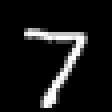

In [16]:
println("Predicted value = $(pred[1])")
a = reshape(test_imgs[1], NROWS, NCOLS)

Predicted value = 2


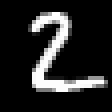

In [17]:
println("Predicted value = $(pred[2])")
a = reshape(test_imgs[2], NROWS, NCOLS)

Predicted value = 1


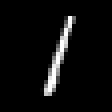

In [18]:
println("Predicted value = $(pred[3])")
a = reshape(test_imgs[3], NROWS, NCOLS)

## Conclusion

When dealing with images, a convolutional neural network generally does an amazing job at recognizing patterns. This blog post was a non-technical introduction to the topic. While Python is the tool of predilection in machine learning (Keras, TensorFlow, etc.), my guess is that Julia will get increasingly popular because Julia is both easy to use and fast.

## References

* This blog post is heavily based on this Flux.jl tutorial: https://github.com/FluxML/model-zoo/blob/master/vision/mnist/conv.jl 
* On the links between CNN and PDEs: https://mitmath.github.io/18337/lecture14/pdes_and_convolutions
* A full course on CNN. Most of the content is available online: http://cs231n.github.io/convolutional-networks/